In [ ]:
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
import random
from math import *

In [ ]:
"""declaring global constants"""
avogadro = 6.02214086e23
boltzmann = 1.38064852e-23
ndim = 3

In [ ]:
T_i_ = np.zeros(10000)
step_ = np.zeros(10000)
etot_avg_ = np.zeros(10000)
P_ = np.zeros(10000)
Z_ = np.zeros(10000)
KE_= np.zeros(10000)
PE_= np.zeros(10000)
rho_ = np.zeros(10000)
v_ = np.zeros(10000)
v2_ = np.zeros(10000)

In [ ]:
def sign(a, b):
    """
    The sign function: sign(a, b) returns 'a' with the sign of 'b'
    """
    if b > 0:
        return a
    elif b < 0:
        return -a
    elif b == 0:
        return a

#PARAMETERS

dim =3
n_steps=5000
n=250
dt=0.0001
T_0=300
sig=1
eps=1
r_ctf=2.5*sig
U_at_ctf=4*eps*((sig/r_ctf)**12-(sig/r_ctf)**6)
dU_at_ctf=24*eps*(2*(sig/r_ctf)**13-(sig/r_ctf)**7)
bs=10*sig
vol=bs**3
rho=n/vol
ign=250
#-------------------------------------------------
#INITIALIZATION
#-------------------------------------------------
pos =np.zeros([dim,n])
vel =np.zeros([dim,n])
acc =np.zeros([dim,n])
for j in range (n):
    for i in range (dim):
        pos[i,j] = random.uniform(0,bs)
        vel[i,j] = random.uniform(0,1)
#-------------------------------------------------
#COM
#-------------------------------------------------
com = np.zeros([dim])
for i in range (dim):
    for j in range (n):
        com[i]+=pos[i,j]
    com[i]=com[i]/n

for i in range (dim):
    for j in range (n):
        pos[i,j]=pos[i,j]-com[i]
#---------------------------------------------
P_S=0
K_S=0
p_S=0
T_S=0
f_tpz=open('tpz.out','w')
f_kpe=open('kpe.out','w')
f_xyz=open('xyz.out','w')
R=np.zeros([dim,n,n])
r=np.zeros([dim,n,n])
#---------------------------------------------
#MAIN LOOP
#---------------------------------------------

for step in tqdm(range (1, n_steps+1)):
    #periodic boundary
    pos[np.where(pos<0.5)]-=1
    pos[np.where(pos>0.5)]+=1
    #force calculation
    acc=np.zeros([dim,n])
    pot=np.zeros([n])
    vrl=0.0

    for i in range(n):
        for j in range(i+1,n):
            if j != i:
                r2=np.zeros([n,n])
                for k in range(dim):
                    R[k, i , j]=pos[k,i]-pos[k,j]
                    if abs(R[k,i,j])>0.5:
                        R[k,i,j]=R[k,i,j]-sign(1.0 ,R[k,i,j])
                    r[k,i,j] = bs*R[k,i,j]
                    r2[i,j] += r[k,i,j]*r[k,i,j]
                if r2[i,j] < r_ctf**2:
                    r1=sqrt(r2[i,j])
                    ri2=1.0/r2[i,j]
                    ri6=ri2**3
                    ri12=ri6**2
                    sig6=sig**6
                    sig12=sig6**2
                    u=4*eps*(sig12*ri12-sig6*ri6)-U_at_ctf-r1*dU_at_ctf
                    du=24*eps*(2*sig12*ri12-sig6*ri6)+dU_at_ctf*sqrt(ri2)
                    pot[j]=pot[j]+u
                    vrl-=du*r2[i,j]
                    for k in range(dim):
                        acc[k,i]=acc[k,i]+du*R[k,i,j]+0.5*(random.uniform(-1,1) - (vel[k,i]))/dt
                        acc[k,j]=acc[k,j]-du*R[k,i,j]+0.5*(random.uniform(-1,1) - (vel[k,j]))/dt

    vrl= -vrl/dim
    #---------------------------------------------
    #Update Position
    pos=pos+vel*dt+0.5*acc*dt**2
    #---------------------------------------------
    #Compute Temperature
    kin = np.zeros([n])
    v2 = np.zeros([n])
    for i in range(n):
        for j in range(dim):
            v2[i] += vel[j,i]**2*bs*bs
        kin[i] = 0.5*v2[i]
    k_avg = np.sum(kin)/n
    T_i= 2*k_avg/dim
    B= sqrt(T_0/T_i)
    #---------------------------------------------
    #Update Velocity
    vel = B*vel+0.5*acc*dt
    vel += 0.5*acc*dt
    #---------------------------------------------
    #Compute temperature
    kin = np.zeros([n])
    v2 = np.zeros([n])
    for i in range(n):
        for j in range(dim):
            v2[i] += vel[j,i]**2*bs*bs
        kin[i] = 0.5*v2[i]

    k_avg = np.sum(kin)/n
    T_i= 2*k_avg/dim
    B= sqrt(T_0/T_i)
    #---------------------------------------------
    p_avg = sum(pot)/vol
    etot_avg = p_avg + k_avg
    P= rho*T_i + vrl/vol
    Z = P*vol/(n*T_i)
    f_tpz.write('%e %e %e %e %e \n' % (step, step*dt, k_avg, p_avg, etot_avg))

    f_kpe.write('%e %e %e %e %e \n' % (step, step*dt, T_i, P, Z))
    #---------------------------------------------
    #Write position Components
    f_xyz.write("%d \n\n" %(step))
    for i in range(n):
        f_xyz.write("%e %e %e \n" %(pos[0,i]*bs,pos[1,i]*bs,pos[2,i]*bs))

    #---------------------------------------------
    if step > ign:
        K_S += k_avg
        P_S += p_avg
        T_S += T_i
        p_S += P
#---------------------------------------------
    step_[step-1]=step
    T_i_[step-1]=T_i
    etot_avg_[step-1]=etot_avg
    P_[step-1]=P
    Z_[step-1]=Z
    KE_[step-1]=K_S
    PE_[step-1]=P_S
    rho_[step-1]=rho
#END MAIN LOOP
print('Statistical Averages')
print('Temeperature = %e' % (T_S/(n_steps-ign)))
print('Pressure = %e' % (p_S/(n_steps-ign)))
print('Kinetic Energy = %e' % (K_S/(n_steps-ign)))
print('Potential Energy = %e' % (P_S/(n_steps-ign)))
print('Total Energy = %e' % ((K_S+P_S)/(n_steps-ign)))

f_tpz.close()
f_kpe.close()

100%|██████████| 5000/5000 [47:07<00:00,  1.77it/s] 

Statistical Averages
Temeperature = 2.999409e+02
Pressure = 7.497597e+01
Kinetic Energy = 4.499114e+02
Potential Energy = 1.560849e-03
Total Energy = 4.499129e+02


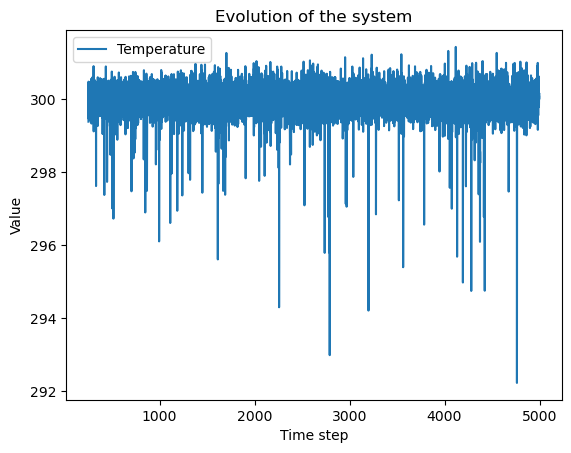

In [ ]:
#plot the evolutions
plt.plot(step_[250:4998], T_i_[250:4998], label='Temperature')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Evolution of the system')
plt.legend()
plt.show()

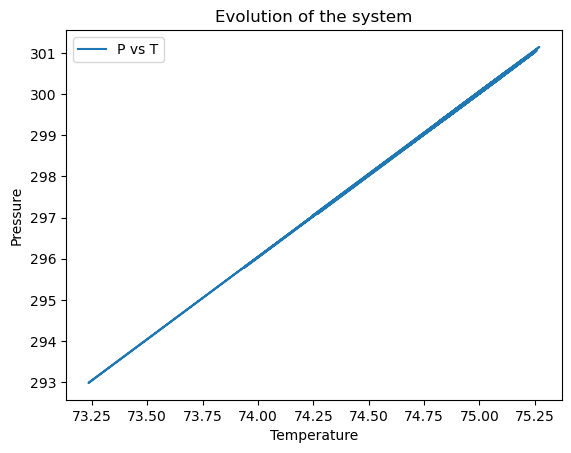

In [ ]:
plt.plot(P_[2500:2998], T_i_[2500:2998], label='P vs T')
plt.xlabel('Temperature')
plt.ylabel('Pressure')
plt.title('Evolution of the system')
plt.legend()
plt.show()

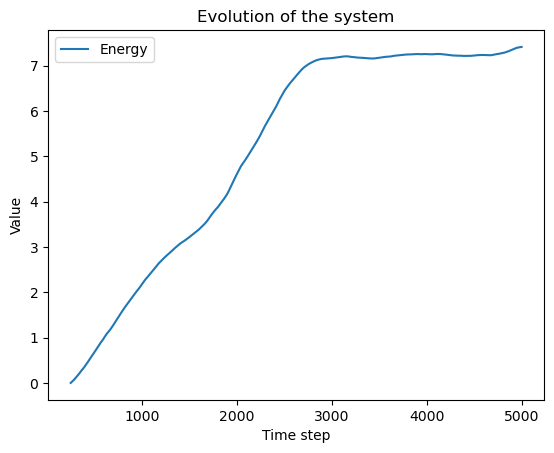

In [ ]:
plt.plot(step_[250:4998], PE_[250:4998], label='Energy')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Evolution of the system')
plt.legend()
plt.show()